### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns

import metabolinks as mtl
import metabolinks.transformations as transf
from metabolinks.similarity import mz_similarity

import scaling as sca
import multianalysis as ma

In [2]:
%matplotlib inline

### Similarity analysis with Metabolights data: 
#### Wolbachia Modulates Lipid Metabolism in Aedes albopictus Mosquito Cells

Article link: http://europepmc.org/backend/ptpmcrender.fcgi?accid=PMC4959074&blobtype=pdf

Metabolights dataset link: https://www.ebi.ac.uk/metabolights/MTBLS210

Four groups including a quality control and 3 groups of Aedes albopictus Aa23 cells with different amount of replicates (slightly unbalanced data).
- QC - Quality Control samples - 7 samples (one of the datasets had 9, but to compare with each other 2 were left out).
- L_A/LA - Aedes albopictus Aa23 cells with no infection - 7 samples.
- L_AM/LAM - Aedes albopictus Aa23 cells infected with Mel - 6 samples.
- L_AP/LAP - Aedes albopictus Aa23 cells infected with MelPop - 6 samples.

Metabolomics approach:
- Negative-ion-mode direct-infusion (DI) FT-ICR MS was conducted using a hybrid 7-T linear ion trap FT-ICR mass spectrometer 
- Reversed-phase high-performance liquid chromatography (RPLC) FT-ICR MS-based analysis - LC-FT-ICR MS.
- “Replicate filtering,” peaks were retained if they were found in two out of three technical replicates.

Data characteristics:
- Normalization was performed using the probabilistic quotient normalization (PQN) method by the authors but since the following procedures they described (missing value imputation) weren't performed onthe dataset obtained, we can't be sure the data we have has already been normalized.
- The data has a lot of peaks m/z/ features although some filtering of peaks was done with a credbile amount of missing values and is therefore suited to the binary analysis that we want to test and to compare with mroe conventional methods. 

All further changes to code will first be implemented on the original similarity_analysis. This is an altered version of said original.

To better understand the functions used outside of normal Python packages, see scaling.py and multianalysis.py where they are better described and try tosay what is happening in each block of code.

## Similarity analysis

aligned_all_lcms = LCMS dataset or derived from the LCMS dataset.

aligned_all_dims = DIMS dataset or derived from the DIMS dataset.

### NOTE: Both are obtained in negative mode (separation is between DI-FT-ICR-MS and LC-FT-ICR-MS).

In [3]:
file = pd.read_excel('Metabolights/LCMS_SFPM.xlsx', header=[0])#, sep='\t')
file = file.set_index(file.columns[0])

labels = ["LA","LA","LA","LA","LA","LA","LA","LAM","LAM","LAM","LAM","LAM","LAM",
        "LAP","LAP","LAP","LAP","LAP","LAP","QC","QC","QC","QC","QC","QC","QC","QC","QC"]
aligned_file = mtl.add_labels(file.T, labels)

#Replacing 0 values with missing number values for better missing value imputation and feature removal
aligned_all_lcms = aligned_file.replace({0:np.nan})
aligned_all_lcms = aligned_all_lcms.iloc[:,:-2]

In [4]:
aligned_all_lcms

label              LA                                                         \
M/Z             L_A_1      L_A_2      L_A_3      L_A_4      L_A_5      L_A_6   
120.10314    298189.0   275662.0   296459.0   258985.0   282028.0   254251.0   
120.11130    156750.0   148956.0   216123.0   102372.0    89009.6    47934.1   
120.30174     84534.0    70537.2   119235.0        NaN    71284.0        NaN   
120.30368     84227.2    74510.0    81191.1        NaN    73782.1    72899.9   
120.50587    201077.0   196509.0   261048.0   136231.0   147320.0    85193.6   
...               ...        ...        ...        ...        ...        ...   
1198.02874  8230540.0  6536560.0  7820240.0  5858920.0  5152390.0  2393490.0   
1198.53346    74876.5    70718.0    66839.2    82543.1    95859.7   106888.0   
1198.97567   263460.0   247239.0   381158.0   270500.0   369238.0   155519.0   
1199.03257  3498890.0  2882190.0  3676900.0  2435460.0  2411190.0   991750.0   
1199.98321   304348.0   189371.0   610998.0   164258.0   173689.0    75934.3   

label                        LAM                       ...        LAP  \
M/Z             L_A_7     L_AM_1     L_AM_2    L_AM_3  ...     L_AP_4   
120.10314    310109.0   175538.0   179911.0   87182.5  ...   204828.0   
120.11130    164258.0        NaN   142444.0   46934.6  ...   155435.0   
120.30174     71022.1        NaN    76850.8       NaN  ...    69385.8   
120.30368     92150.1        NaN        NaN       NaN  ...    55615.9   
120.50587    149527.0    67181.3   177639.0   61035.6  ...   155704.0   
...               ...        ...        ...       ...  ...        ...   
1198.02874  6565170.0  1571230.0  1319890.0  240533.0  ...  3553720.0   
1198.53346    83121.3    80758.2    69560.9   69337.6  ...    76748.3   
1198.97567   488573.0        NaN   228134.0       NaN  ...   103424.0   
1199.03257  3111750.0   667609.0   605634.0   90119.3  ...  1475100.0   
1199.98321   534459.0        NaN   390551.0       NaN  ...   103921.0   

label                                    QC                                   \
M/Z            L_AP_5     L_AP_6      L_QC1      L_QC2      L_QC3      L_QC4   
120.10314    253463.0   185198.0   333272.0   236646.0   236331.0   223715.0   
120.11130    160229.0   124451.0    73079.7   114104.0   120744.0   119509.0   
120.30174     83760.4    72146.4    71621.1    52046.1        NaN    52187.3   
120.30368     65111.3        NaN   107271.0    71771.6    68916.3    56911.9   
120.50587    195135.0   103610.0   185509.0   146151.0   151238.0   149370.0   
...               ...        ...        ...        ...        ...        ...   
1198.02874  4542900.0  2325720.0  1728810.0  2142870.0  3224000.0  3867870.0   
1198.53346    84550.0    79107.5        NaN        NaN        NaN        NaN   
1198.97567   156080.0        NaN        NaN        NaN   128261.0   146389.0   
1199.03257  2189200.0  1119310.0   739623.0   832115.0  1385980.0  1620400.0   
1199.98321   218321.0   110954.0        NaN        NaN   140778.0   109148.0   

label                                        
M/Z             L_QC5      L_QC6      L_QC7  
120.10314    177991.0   203552.0   217611.0  
120.11130     97363.3   113306.0   113030.0  
120.30174     44471.2    74282.4    68619.1  
120.30368         NaN    55520.6    72303.5  
120.50587    126834.0   126358.0   147914.0  
...               ...        ...        ...  
1198.02874  2710830.0  3398030.0  3599270.0  
1198.53346        NaN        NaN        NaN  
1198.97567    89832.0   139400.0   202873.0  
1199.03257  1089140.0  1416760.0  1571700.0  
1199.98321    86270.2   121995.0   209271.0  

[4736 rows x 26 columns]

In [5]:
file = pd.read_excel('Metabolights/DIMS_SFPM.xlsx', header=[0])#, sep='\t')
file = file.set_index(file.columns[0])
aligned_file = file.T
aligned_file.columns = aligned_all_lcms.columns

#labels = ["LA","LA","LA","LA","LA","LA","LA","LAM","LAM","LAM","LAM","LAM","LAM",
#        "LAP","LAP","LAP","LAP","LAP","LAP","QC","QC","QC","QC","QC","QC","QC"]
#aligned_file = mtl.add_labels(file, labels)

#Replacing 0 values with missing number values for better missing value imputation and feature removal
aligned_all_dims = aligned_file.replace({0:np.nan})

In [6]:
aligned_all_dims

label               LA                                                        \
M/Z              L_A_1      L_A_2      L_A_3      L_A_4      L_A_5     L_A_6   
147.02981      141.373    529.647    751.303    387.323    613.460   389.449   
147.06618      215.595    611.880    220.121    535.323    742.659   567.648   
152.98622          NaN    417.922    449.732    547.415    515.512   285.717   
153.09201      335.237    317.428        NaN    560.899    476.772   474.562   
157.03558     1187.760    759.193    987.702    938.360    876.509   595.691   
...                ...        ...        ...        ...        ...       ...   
1167.79175   18541.300  12706.800  15766.600   7807.500   7541.780  5128.650   
1168.07308  312816.000  71157.200  69661.200  52828.600  58606.000  7158.820   
1170.94454   24919.600  12639.400  17123.000   7947.400   6219.860       NaN   
1171.95609   46869.900  24609.800  31476.800  10944.100  10380.200  4101.090   
1172.95921   34456.600  18190.400  23330.200   9914.050   7379.760  2974.530   

label                        LAM                        ...        LAP  \
M/Z             L_A_7     L_AM_1     L_AM_2     L_AM_3  ...     L_AP_4   
147.02981     396.252    240.421    913.711    361.560  ...    752.251   
147.06618     292.277    296.180    762.182    321.168  ...    446.819   
152.98622     750.963    445.249    830.611    496.677  ...    581.451   
153.09201     408.620    401.821    877.753    400.712  ...    372.183   
157.03558     852.972    850.039    608.547    915.068  ...    964.401   
...               ...        ...        ...        ...  ...        ...   
1167.79175  29129.600   9753.180   8419.630  10209.200  ...   8903.450   
1168.07308  32656.100   9115.910  29142.600  13698.500  ...  27397.300   
1170.94454   9391.190   9216.350   2966.530   4628.560  ...  13147.200   
1171.95609  14389.500  21744.500  15322.100  15601.800  ...  28881.300   
1172.95921  10640.000  15227.800  10835.400  11751.300  ...  21048.100   

label                                     QC                                   \
M/Z            L_AP_5      L_AP_6      L_QC1      L_QC2      L_QC3      L_QC4   
147.02981         NaN     599.731    317.964        NaN    434.039    631.032   
147.06618     441.119         NaN    327.325    265.603    287.214    454.426   
152.98622     337.184     554.139    223.674    196.669    365.421    629.389   
153.09201     375.983     252.075    387.883    248.756    411.982    432.399   
157.03558     939.891     797.058   1201.610    945.972   1028.060   1075.500   
...               ...         ...        ...        ...        ...        ...   
1167.79175   6948.880   10341.800  15064.600  13413.900  12996.900  17407.500   
1168.07308  56826.300  176539.000  91593.900  48529.400  96967.800  70155.600   
1170.94454   5531.760         NaN  15195.000   7844.820   6915.660  10569.600   
1171.95609  13982.700   18580.700  36281.300  19467.000  15588.600  24604.800   
1172.95921  10631.400   13897.100  26614.500  13907.600  11754.800  18379.700   

label                                        
M/Z             L_QC5      L_QC6      L_QC7  
147.02981     312.512    800.613        NaN  
147.06618     503.397    514.660    505.404  
152.98622     402.997    914.873    369.908  
153.09201     523.939        NaN    548.011  
157.03558    1037.930    538.448   1207.290  
...               ...        ...        ...  
1167.79175  13605.000  12618.200  10983.500  
1168.07308  58579.300  20985.400  94733.800  
1170.94454  11242.500   8643.350   9180.930  
1171.95609  26624.300  19783.400  20346.900  
1172.95921  19165.100  14649.700  15170.100  

[2044 rows x 26 columns]

### Compute m/z similarities

In [7]:
sim_lcms = mz_similarity(aligned_all_lcms, has_labels = True)
sim_dims = mz_similarity(aligned_all_dims, has_labels = True)

In [8]:
print(sim_lcms)


Sample similarity, counts of common peaks
        L_A_1  L_A_2  L_A_3  L_A_4  L_A_5  L_A_6  L_A_7  L_AM_1  L_AM_2  \
L_A_1    4347   4235   4207   4109   4170   3950   4149    3754    3853   
L_A_2    4235   4515   4337   4225   4304   4081   4249    3843    3982   
L_A_3    4207   4337   4479   4156   4280   4037   4261    3823    3970   
L_A_4    4109   4225   4156   4328   4191   3994   4115    3726    3825   
L_A_5    4170   4304   4280   4191   4434   4081   4250    3806    3924   
L_A_6    3950   4081   4037   3994   4081   4226   4031    3673    3740   
L_A_7    4149   4249   4261   4115   4250   4031   4395    3771    3901   
L_AM_1   3754   3843   3823   3726   3806   3673   3771    4015    3805   
L_AM_2   3853   3982   3970   3825   3924   3740   3901    3805    4166   
L_AM_3   3409   3562   3531   3441   3506   3405   3474    3446    3563   
L_AM_4   3821   3925   3899   3799   3874   3755   3837    3874    3871   
L_AM_5   3851   3991   3964   3858   3959   3832   3918  

In [9]:
print(sim_dims)


Sample similarity, counts of common peaks
        L_A_1  L_A_2  L_A_3  L_A_4  L_A_5  L_A_6  L_A_7  L_AM_1  L_AM_2  \
L_A_1    1835   1783   1615   1793   1761   1717   1669    1722    1705   
L_A_2    1783   1981   1755   1938   1897   1866   1791    1860    1836   
L_A_3    1615   1755   1795   1753   1732   1689   1694    1675    1662   
L_A_4    1793   1938   1753   1991   1921   1887   1803    1872    1842   
L_A_5    1761   1897   1732   1921   1951   1859   1774    1841    1815   
L_A_6    1717   1866   1689   1887   1859   1916   1754    1821    1775   
L_A_7    1669   1791   1694   1803   1774   1754   1832    1726    1697   
L_AM_1   1722   1860   1675   1872   1841   1821   1726    1916    1800   
L_AM_2   1705   1836   1662   1842   1815   1775   1697    1800    1889   
L_AM_3   1505   1642   1568   1632   1617   1589   1555    1622    1601   
L_AM_4   1705   1841   1664   1848   1812   1780   1699    1814    1796   
L_AM_5   1635   1762   1604   1773   1739   1728   1650  

### Global metadata for consistency between tables and plots

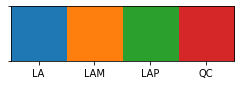

In [10]:
sample_names = aligned_all_dims.cdl.samples
all_labels = aligned_all_dims.cdl.labels
unique_labels = aligned_all_dims.cdl.unique_labels

# customize these colors
colours = sns.color_palette('tab10', 4)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

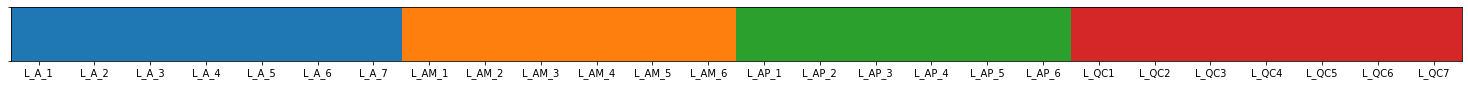

In [11]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Data transformations

### Each Dataset is transformed to binary or ...

3 types of processing are made:

Imp (Ionly) - Only Missing Value Imputation.

P - Missing Value Imputation and Pareto Scaling.

NGP - Missing Value Imputation, glog transformation and Pareto Scaling.

Since the state of the data we have is unknown among the different Metabolights datasets (some are known to have performed some kind of normalization, others there isn't any certainties) and since the reference features also are, for the most part, not known, normalization procedures aren't applied here as they were in previous dataset and the "absence of treatment" in the data is also tested since most of these dataset already suffered some kind of treatment.

In [12]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

def compute_transf(dataset, norm_ref=None, lamb=None):
    intensities = dataset
    dicto = {}
    
    imputed = transf.fillna_frac_min(intensities, fraction=0.5)
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    P = transf.pareto_scale(imputed)
    #NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    dicto['binary'] = df_to_bool(intensities)
    dicto['Ionly'] = imputed
    dicto['P'] = P
    #dicto['NP'] = NP
    dicto['NGP'] = NGP
    
    return dicto

In [13]:
# DIMS dataset
treat_dims = compute_transf(aligned_all_dims)

# LCMS dataset
treat_lcms = compute_transf(aligned_all_lcms)

## Similarity analysis (Jaccard)

In [14]:
def plot_jaccard_sims(dataset, title=''):
    intensities = dataset
    sims = mz_similarity(intensities, has_labels=True)
    #grid_kws = {"height_ratios": (0.4, 0.4, 0.02)}
    f, ax = plt.subplots(1,2, figsize=(14, 7), constrained_layout=True) # gridspec_kw=grid_kws,

    hm = sns.heatmap(sims.sample_similarity_jaccard, annot=False, square=True, ax=ax[0], cmap='YlGnBu', cbar=None)
    hm = sns.heatmap(sims.label_similarity_jaccard, annot=True, square=True, ax=ax[1], cmap='YlGnBu')
    
    #Correction for heatmap bug in latest version of seaborn
    bottom, top = ax[0].get_ylim()
    ax[0].set_ylim(bottom + 0.5, top - 0.5)
    bottom, top = ax[1].get_ylim()
    ax[1].set_ylim(bottom + 0.5, top - 0.5)
    
    ax[0].set_title('Sample similarity')
    ax[1].set_title('Group similarity')
    f.suptitle(title, fontsize=16)

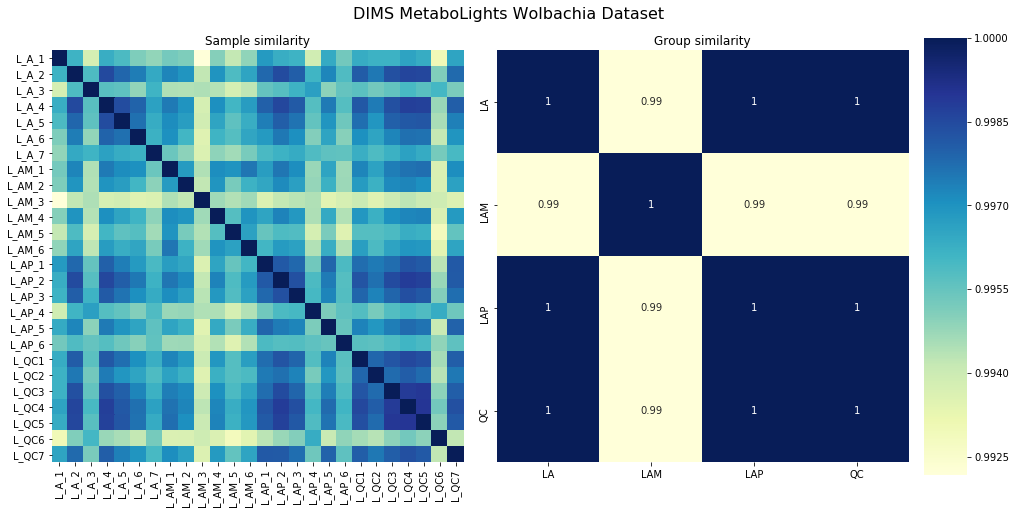

In [15]:
plot_jaccard_sims(aligned_all_dims, 'DIMS MetaboLights Wolbachia Dataset')

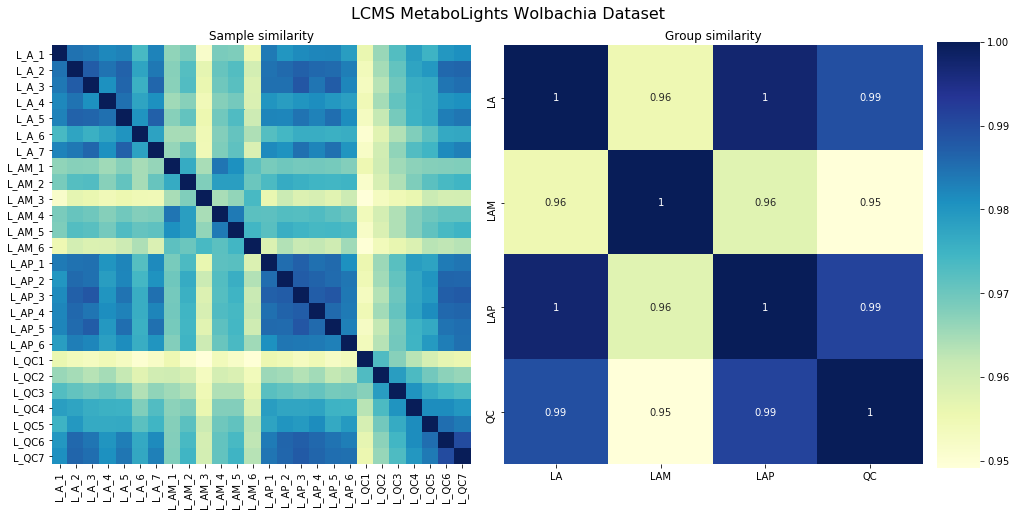

In [16]:
plot_jaccard_sims(aligned_all_lcms, 'LCMS MetaboLights Wolbachia Dataset')

#### Verification that `dist.pdist()` produces the same result as `mz_similarity()`

In [17]:
intensities = aligned_all_dims
neg_01 = treat_dims['binary']

scipy_jdist = dist.pdist(neg_01.T, metric='jaccard')
df_scipy_dist = pd.DataFrame(dist.squareform(scipy_jdist), index=sample_names, columns=sample_names)

#sim_neg = mz_similarity(intensities, has_labels=True)
jsim = sim_dims.sample_similarity_jaccard
jsim.index.name = 'M/Z'
jsim.columns.name = 'M/Z'
jdist = 1 - jsim

from pandas.testing import assert_frame_equal
assert_frame_equal(jdist, df_scipy_dist)
# No exception should be raised!

Dendogram from Jaccard distance, DIMS MetaboLights Wolbachia Dataset (cophenetic = 1.00000)


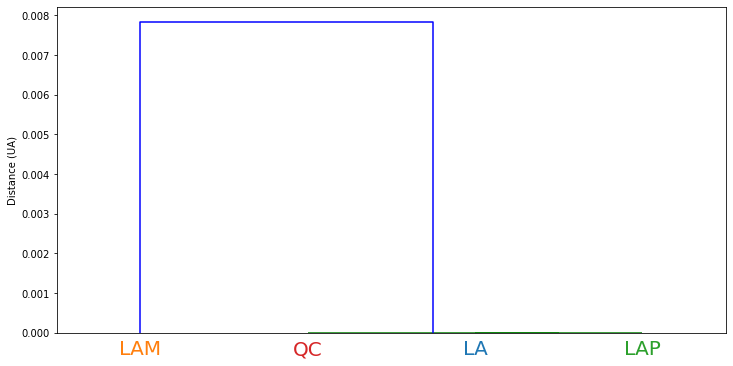

In [18]:
jdist = dist.squareform(1 - sim_dims.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, DIMS MetaboLights Wolbachia Dataset (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Dendogram from Jaccard distance, LCMS MetaboLights Wolbachia Dataset - Alignment: 1-6 (cophenetic = 0.99118)


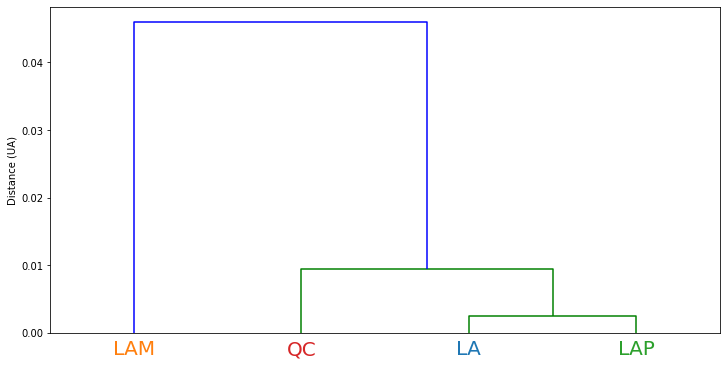

In [19]:
jdist = dist.squareform(1 - sim_lcms.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, LCMS MetaboLights Wolbachia Dataset - Alignment: 1-6 (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

## Hierarchical Cluster Analysis (agglomerative)


### Non-binary Similarity Analysis

All samples need to have missing value imputation with the function fillna_frac_min(dataset, fraction=0.5) of transformation from metabolinks (replace missing features with half of the minimum intensity of the full dataset).

After that, the rest of the data processing can vary where different processing methods were applied in different combinations:

##### Glog transformation/ log2 transformation (glog from transformations in metabolinks) - G;
##### Pareto Scaling (pareto_scale from transformations in metabolinks) - P.
Three combinations were used and compared: No treatment (Imp), only Pareto Scaling (P) and glog transformation and Pareto Scaling (NGP).

In [20]:
def plot_dendogram(Z, title=''):
    fig = plt.figure(figsize=(16,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=15, above_threshold_color='b')
    #Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 13)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

### DIMS Dataset - Dendograms with each differently-treated Grapevine Dataset

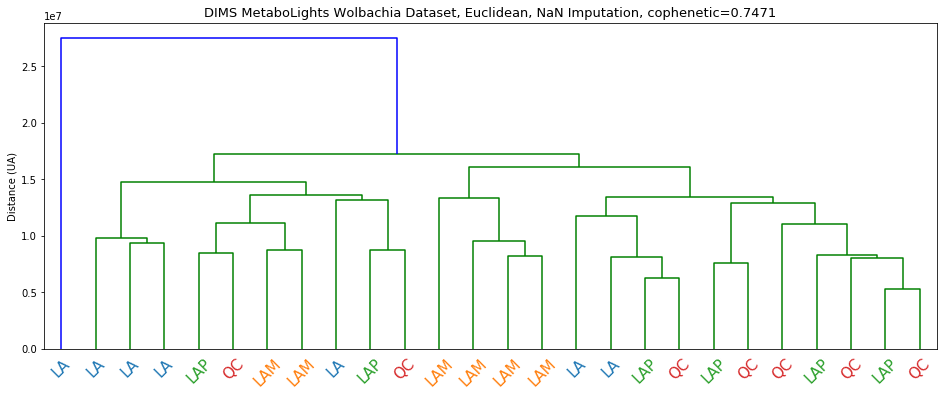

In [21]:
# Missing Value Imputation only
Imp_dims = treat_dims['Ionly']
dist_Imp_dims = dist.pdist(Imp_dims.T, metric = 'euclidean')
Z_Imp_dims = hier.linkage(dist_Imp_dims, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_dims, dist_Imp_dims)[0]

title = f'DIMS MetaboLights Wolbachia Dataset, Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_dims, title)

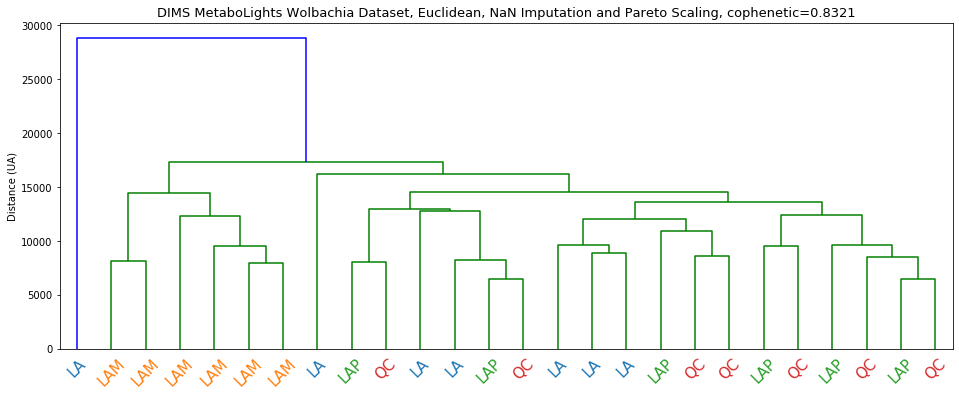

In [22]:
# Imputed and Pareto scaled
P_dims = treat_dims['P']
dist_P_dims = dist.pdist(P_dims.T, metric = 'euclidean')
Z_P_dims = hier.linkage(dist_P_dims, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_dims, dist_P_dims)[0] #method average seems to lead to higher coefficients
title = f'DIMS MetaboLights Wolbachia Dataset, Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_dims, title)

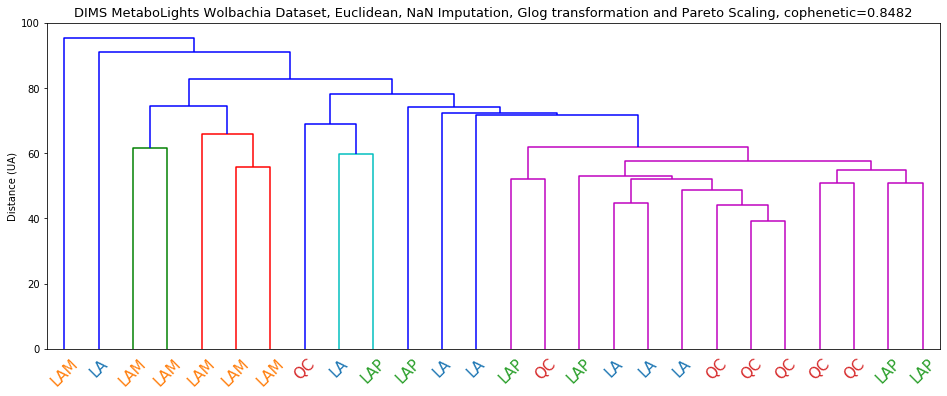

In [23]:
# Imputed, glog transformed and Pareto scaled
NGP_dims = treat_dims['NGP']
dist_NGP_dims = dist.pdist(NGP_dims.T, metric = 'euclidean')
Z_NGP_dims = hier.linkage(dist_NGP_dims, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_dims, dist_NGP_dims)[0] #method average seems to lead to higher coefficients
title = f'DIMS MetaboLights Wolbachia Dataset, Euclidean, NaN Imputation, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_dims, title)

#### Binary Similarity Analysis Methods - Example Dendogram

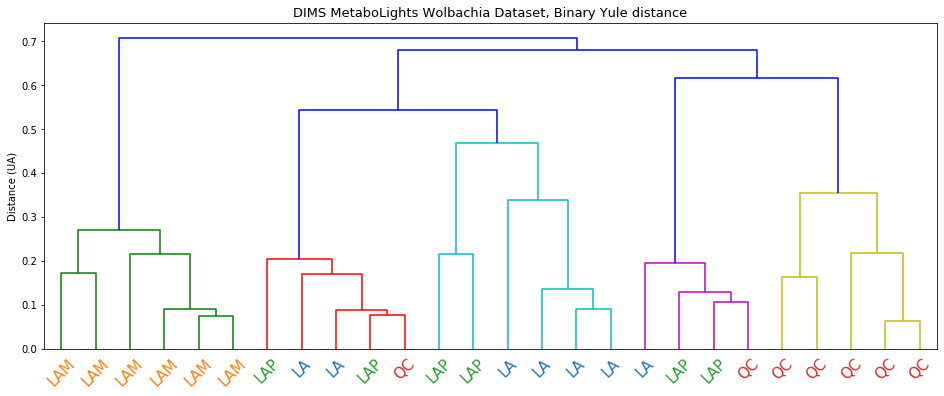

In [24]:
binary = treat_dims['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='yule', method='average')

title = f'DIMS MetaboLights Wolbachia Dataset, Binary Yule distance'
plot_dendogram(Zdice, title)

### LCMS Dataset - Dendograms with each differently-treated Grapevine Dataset

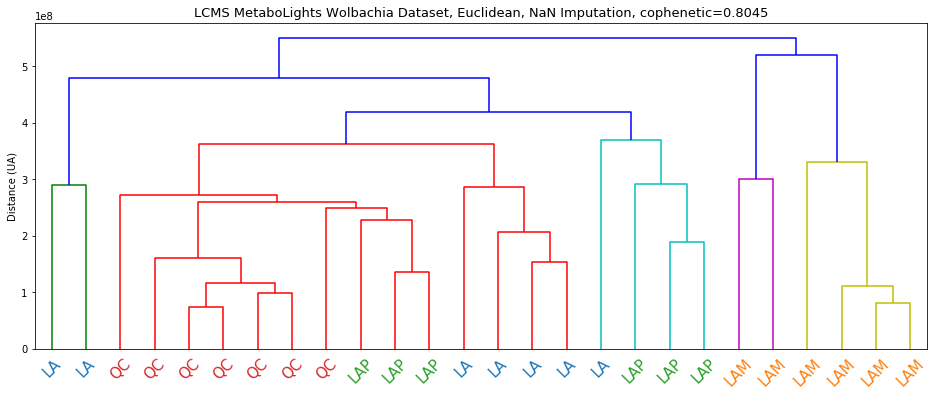

In [25]:
# Missing Value Imputation only
Imp_lcms = treat_lcms['Ionly']
dist_Imp_lcms = dist.pdist(Imp_lcms.T, metric = 'euclidean')
Z_Imp_lcms = hier.linkage(dist_Imp_lcms, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_lcms, dist_Imp_lcms)[0]

title = f'LCMS MetaboLights Wolbachia Dataset, Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_lcms, title)

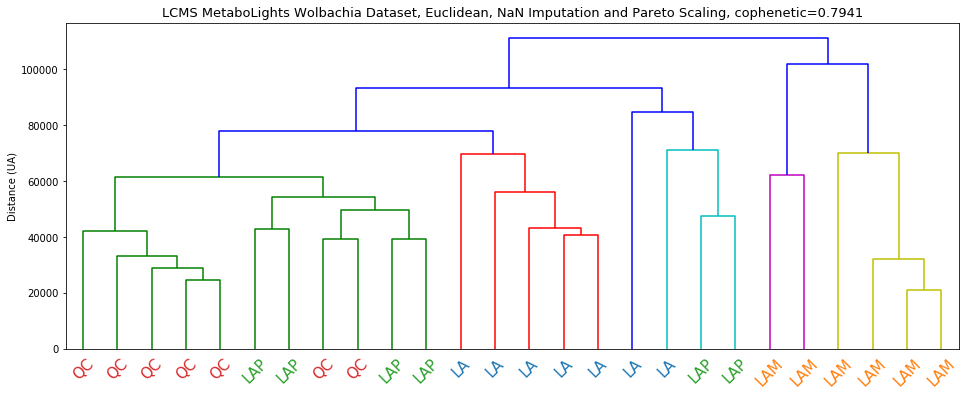

In [26]:
# Imputed and Pareto scaled
P_lcms = treat_lcms['P']
dist_P_lcms = dist.pdist(P_lcms.T, metric = 'euclidean')
Z_P_lcms = hier.linkage(dist_P_lcms, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_lcms, dist_P_lcms)[0] #method average seems to lead to higher coefficients
title = f'LCMS MetaboLights Wolbachia Dataset, Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_lcms, title)

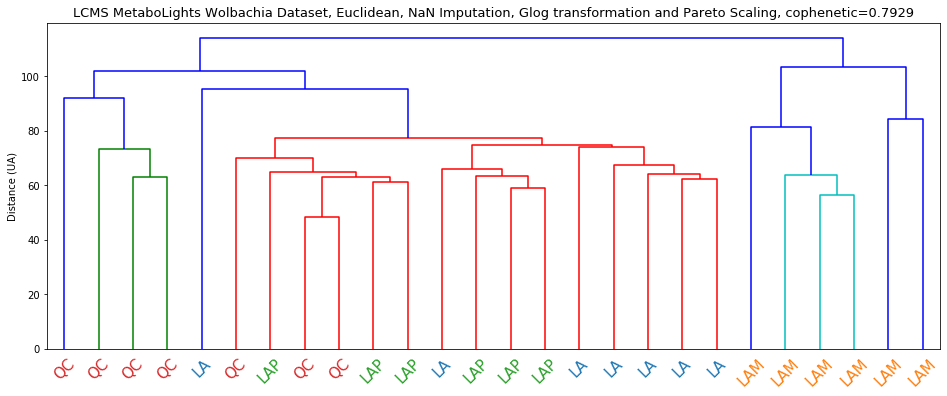

In [27]:
# Imputed, glog transformed and Pareto scaled
NGP_lcms = treat_lcms['NGP']
dist_NGP_lcms = dist.pdist(NGP_lcms.T, metric = 'euclidean')
Z_NGP_lcms = hier.linkage(dist_NGP_lcms, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_lcms, dist_NGP_lcms)[0] #method average seems to lead to higher coefficients
title = f'LCMS MetaboLights Wolbachia Dataset, Euclidean, NaN Imputation, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_lcms, title)

#### Binary Similarity Analysis Methods - Example Dendogram

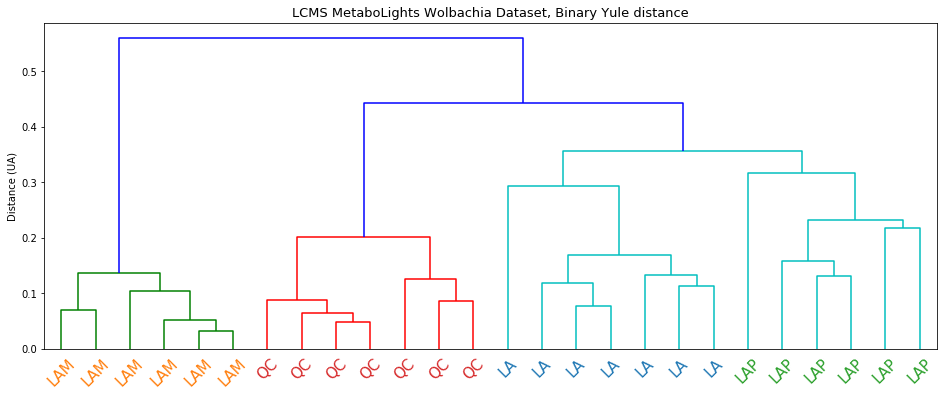

In [28]:
binary = treat_lcms['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='yule', method='average')

title = f'LCMS MetaboLights Wolbachia Dataset, Binary Yule distance'
plot_dendogram(Zdice, title)

### Comparing Dendrograms

#### Two methods so far: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

#### Baker's method

Use of the mergerank function from multianalysis to create a 'rank' of the iteration number two samples were linked to the same cluster.

In [29]:
euclidean = (Z_Imp_dims, Z_P_dims, Z_NGP_dims, Z_Imp_lcms, Z_P_lcms, Z_NGP_lcms)
dist_euclidean = (dist_Imp_dims, dist_P_dims, dist_NGP_dims, dist_Imp_lcms, dist_P_lcms, dist_NGP_lcms)

K_BG = []
S_BG = []
Coph_C = []

for i, (eu, d) in enumerate(zip(euclidean, dist_euclidean)):
    K_BG.append(ma.mergerank(eu)) # Mergerank
    S_BG.append(K_BG[i][K_BG[i]!=0]) # Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_C.append(hier.cophenet(eu, d)) # Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [30]:
print('Pair of samples\tKendall Correlation \tp-value')
print('Imp_dims-P_dims  \t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('Imp_dims-NGP_dims\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples	Kendall Correlation 	p-value
Imp_dims-P_dims  	 0.3639382128007506 	 1.1168304822716736e-31
Imp_dims-NGP_dims	 0.23862760910272182 	 4.263308393281701e-15


According to the explanation given in the R package dendextend

In [31]:
print('Pair of samples\tSpearman Correlation \tp-value')
print('Imp_dims-P_dims  \t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('Imp_dims-NGP_dims\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples	Spearman Correlation 	p-value
Imp_dims-P_dims  	 0.4395833454442859 	 4.330119601198393e-32
Imp_dims-NGP_dims	 0.29867925783903715 	 7.342251634068864e-15


#### Cophenetic Correlation Coefficient

In [32]:
#Acho que se pode aplicar logo a função np.corrcoef visto os elementos que vêm da função cophenet estão sempre na mesma ordem 
#uns em relação aos outros.

In [33]:
print('Pair of samples\tPearson Correlation \tp-value')
print('Imp_dims-P_dims  \t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('Imp_dims-NGP_dims\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples	Pearson Correlation 	p-value
Imp_dims-P_dims  	 0.8617573431848862 	 3.29175142035826e-97
Imp_dims-NGP_dims	 0.41324071355223196 	 7.775485164721219e-15


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

In [34]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
#binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
#3 methods that will be used as representative of the others (others not present have similar variations to one of those 3)
binary = ( 'jaccard', 'hamming', 'yule')

In [35]:
aligned_dims = treat_dims['binary']
aligned_lcms = treat_lcms['binary']

In [36]:
#Application of all "single" steps needed presented in the examples above with every distance metric.
#Negative mode
Z_dims = []
K_dims = []
S_dims = []
Coph_dims = []

for i in range(len(binary)):
    Z_dims.append(hier.linkage(aligned_dims.T, metric = binary[i], method='average')) #Z
    K_dims.append(ma.mergerank(Z_dims[i])) #Mergerank
    S_dims.append(K_dims[i][K_dims[i]!=0]) #Eliminating 0's
    Coph_dims.append(hier.cophenet(Z_dims[i], dist.pdist(aligned_dims.T, metric = binary[i]))) #Cophenetic

In [37]:
#Positive Mode
Z_lcms = []
K_lcms = []
S_lcms = []
Coph_lcms = []

for i in range(len(binary)):
    Z_lcms.append(hier.linkage(aligned_lcms.T, metric = binary[i], method='average')) #Z
    K_lcms.append(ma.mergerank(Z_lcms[i])) #Mergerank
    S_lcms.append(K_lcms[i][K_lcms[i]!=0]) #Eliminating 0's
    Coph_lcms.append(hier.cophenet(Z_lcms[i], dist.pdist(aligned_lcms.T, metric = binary[i]))) #Cophenetic

In [38]:
#Creation of a list with all the "rank" values (in order) for the different metrics: 
#DIMS Euclideans, LCMS Euclideans, DIMS Binaries, LCMS Binaries
S = S_BG + S_dims + S_lcms

#Creation of a list with all the returns from the function cophenetic for the different metrics: 
#DIMS Euclideans, LCMS Euclideans, DIMS Binaries, LCMS Binaries
Coph = Coph_C + Coph_dims + Coph_lcms

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [39]:
#Column names and row names for the dataframes
colnames = ['Imp_dims', 'P_dims', 'NGP_dims', 'Imp_lcms', 'P_lcms', 'NGP_lcms',
            'jaccard_dims', 'hamming_dims', 'yule_dims', 'jaccard_lcms', 'hamming_lcms', 'yule_lcms']
#colnames = ['euc_Imp_pos', 'euc_P_pos', 'euc_NGP_pos','jaccard_pos', 'hamming_pos', 'yule_pos'] - Do LCMS

In [40]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [41]:
#Calculation of correlation coefficient for each method

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,6:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:6], line, df.iloc[6:]])
    prep = pd.concat([prep.iloc[:,:6], lineV.T, prep.iloc[:,6:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode


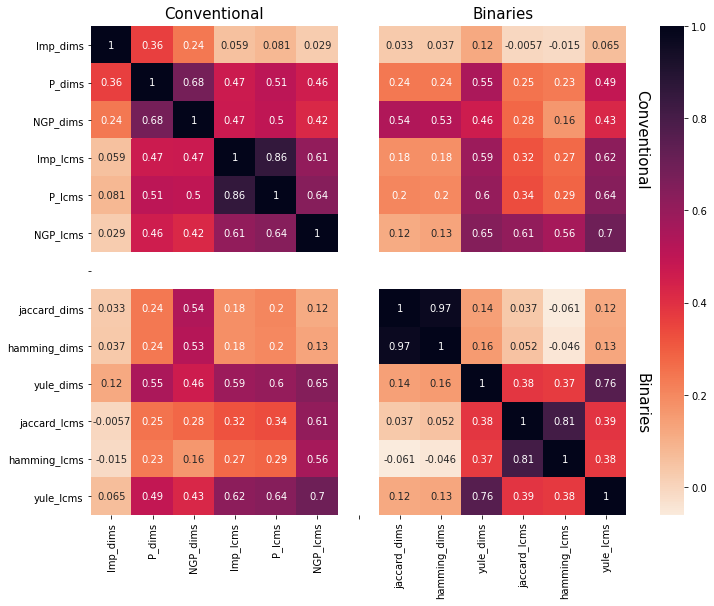

In [42]:
f, ax = plt.subplots(figsize=(12, 9))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(13.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(10,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(13.2,10,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode


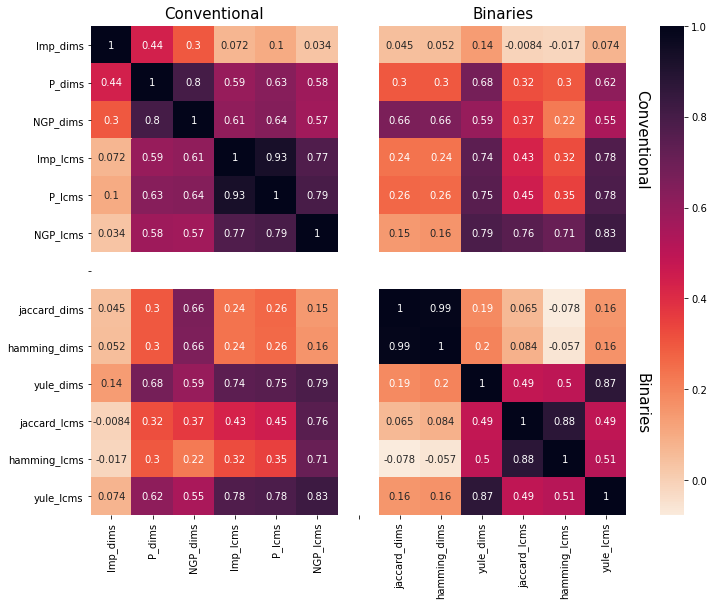

In [43]:
f, ax = plt.subplots(figsize=(12, 9))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(13.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(10,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(13.2,10,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode


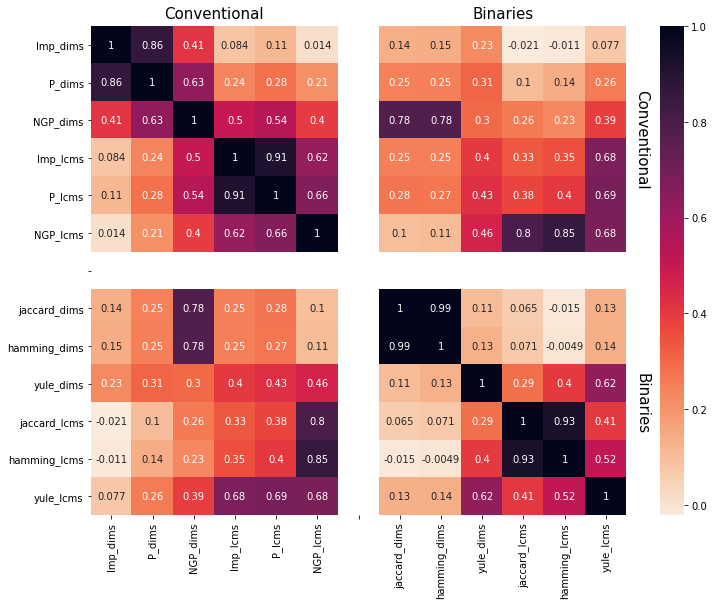

In [44]:
f, ax = plt.subplots(figsize=(12, 9))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(13.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(10,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(13.2,10,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: euclidean_neg, euclidean_pos, neg_binary, pos_binary)

In [45]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(4):
    label_colors2[colnames[3*i]] = col_lbl2[i]
    label_colors2[colnames[3*i+1]] = col_lbl2[i]
    label_colors2[colnames[3*i+2]] = col_lbl2[i]
#for i in range(9):
    #label_colors2[df_K.columns[12+i]] = col_lbl2[4]
    #label_colors2[df_K.columns[21+i]] = col_lbl2[5]

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


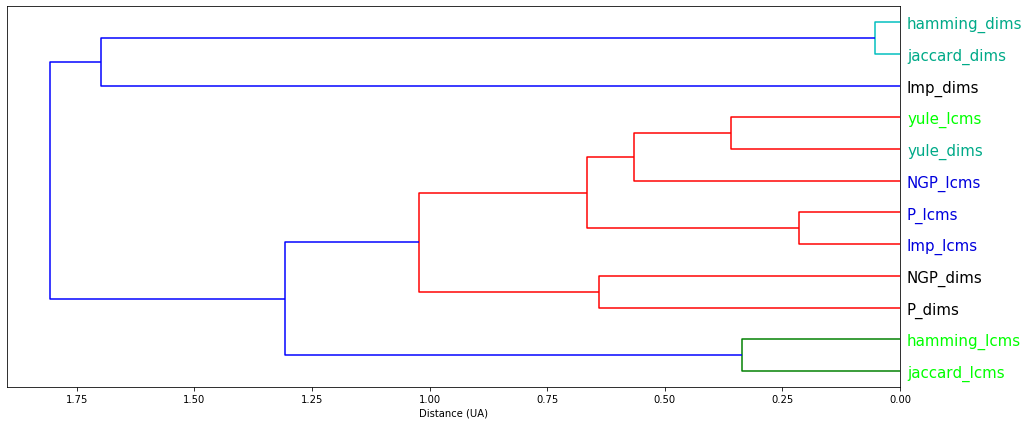

In [46]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_K = hier.linkage(correlations['K'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=correlations['K'].columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


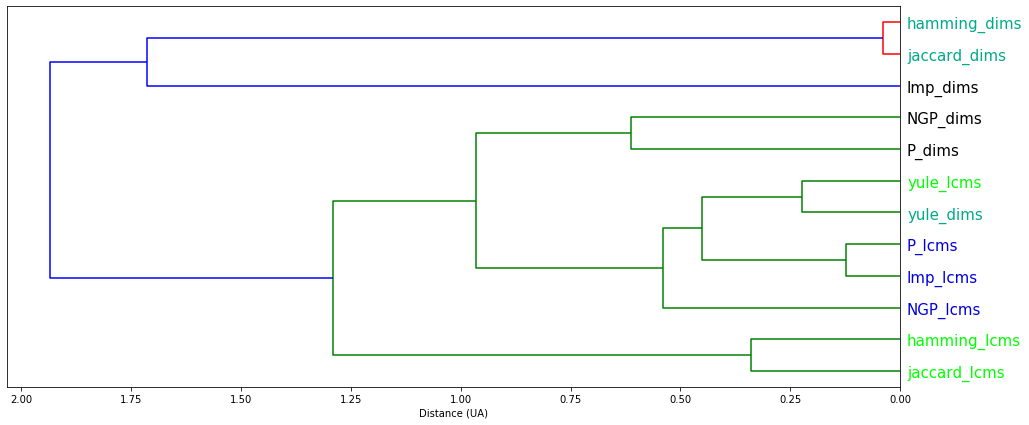

In [47]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_S = hier.linkage(correlations['S'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=correlations['S'].columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


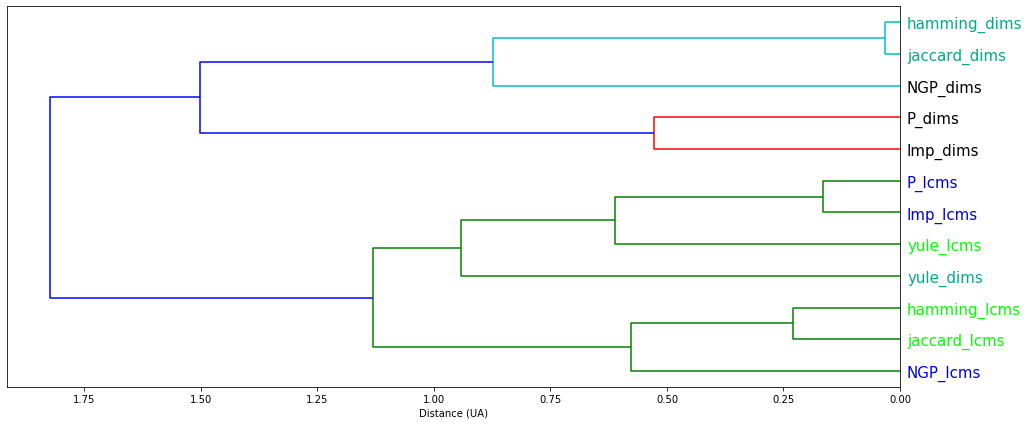

In [48]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_C = hier.linkage(correlations['C'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=correlations['C'].columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [49]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_dims)
Z.extend(Z_lcms)

In [50]:
disc_average = np.zeros((1,12))
disc_median = np.zeros((1,12))
disc_correct = np.zeros((1,12))
for i in range(len(Z)):
    discrim = ma.dist_discrim(aligned_all_lcms, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.dist_discrim(aligned_all_lcms, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,6:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,6:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,6:]], axis = 1)

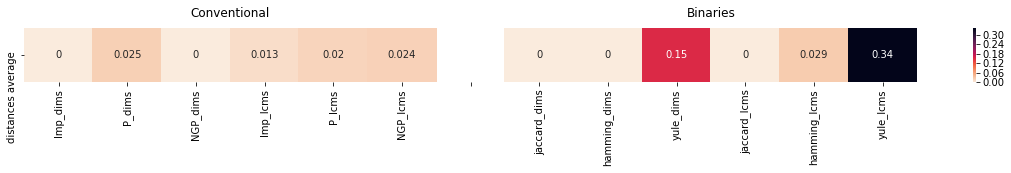

In [51]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
plt.text(10,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

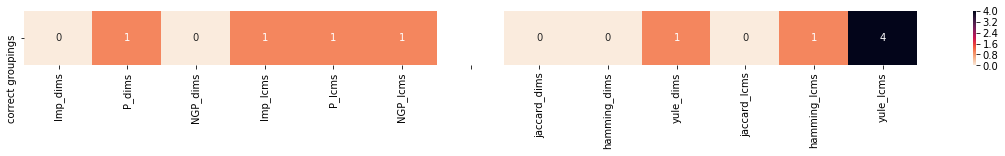

In [52]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [53]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

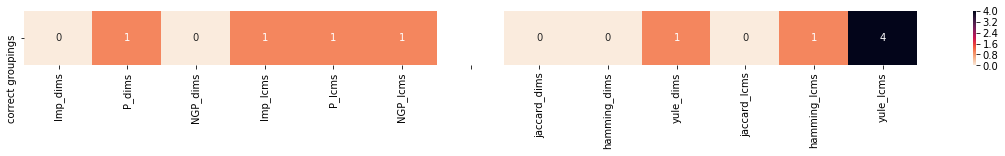

In [54]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [55]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [56]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [57]:
Kmean = skclust.KMeans(n_clusters=4)

In [58]:
a = Kmean.fit(NGP_dims.T)

In [59]:
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{3: ['LA', 'LAP'],
 1: ['LA',
  'LA',
  'LA',
  'LA',
  'LAP',
  'LAP',
  'LAP',
  'LAP',
  'QC',
  'QC',
  'QC',
  'QC',
  'QC',
  'QC'],
 2: ['LA', 'LA', 'LAP', 'QC'],
 0: ['LAM', 'LAM', 'LAM', 'LAM', 'LAM', 'LAM']}

Adjusted Rand Index

In [60]:
from sklearn.metrics import adjusted_rand_score
a.labels_
NGP_dims.cdl.labels
adjusted_rand_score(NGP_dims.cdl.labels,a.labels_)

0.2662987708936675

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used.

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method. The distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. This distance is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean/median of the discrimination distances of all groups is then a measure of the global discrimination distance

Use of the `Kmeans_discrim` function from multianalysis to calculate discrimination distance.

In [61]:
colnames2 = ['Imp_dims', 'P_dims', 'NGP_dims', 'Imp_lcms', 'P_lcms', 'NGP_lcms',
             'aligned_dims', 'aligned_lcms']
#colnames2 = ['euc_Imp_pos', 'euc_P_pos', 'euc_NGP_pos', 'aligned_pos']

In [62]:
Data = (Imp_dims, P_dims, NGP_dims, Imp_lcms, P_lcms, NGP_lcms, aligned_dims, aligned_lcms)

#euclidean = (Imputated_pos, Euc_P_pos, Euc_NGP_pos)#, 
#binaries = (aligned_sp_bin)

In [63]:
disc_average = np.zeros((1,8))
disc_median = np.zeros((1,8))
disc_correct = np.zeros((1,8))
rand_index = np.zeros((1,8))

for i in range(len(Data)):
    discrim = ma.Kmeans_discrim(Data[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.Kmeans_discrim(Data[i], method = 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    
    Kmean = skclust.KMeans(n_clusters=4)
    a = Kmean.fit(Data[i].T)
    rand_index[0,i] = adjusted_rand_score(Data[i].cdl.labels,a.labels_)
    
disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames2)
rand_index = pd.DataFrame(rand_index, index = ['correct groupings'], columns = colnames2)

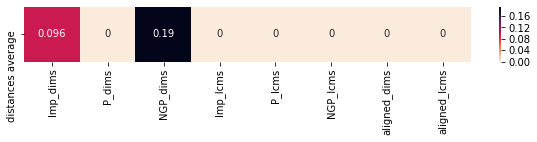

In [64]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

In [65]:
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

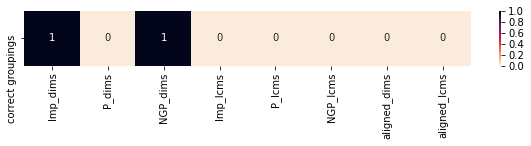

In [66]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

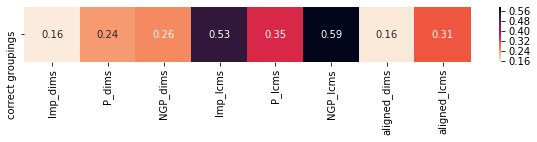

In [67]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(rand_index, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### RandomForests Attempts - 4-fold cross-validation, n_estimators = 200

This section of the notebook takes some time.

### Test number of trees needed for convergence for N, NP, NGP and binary data (both alignments)

Grid search of number of trees from 10 to 1000 for the random forests. See where the cross-validation score stops improving for each one.

#### Takes  considerable time

In [68]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,750,10)}

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv = 6)

In [69]:
# Centralize data information in a dictionary
datasets = {}

datasets['I_dims'] = treat_dims['Ionly']
datasets['P_dims'] = treat_dims['P']
datasets['NGP_dims'] = treat_dims['NGP']
datasets['bin_dims'] = treat_dims['binary']

datasets['I_lcms'] = treat_lcms['Ionly']
datasets['P_lcms'] = treat_lcms['P']
datasets['NGP_lcms'] = treat_lcms['NGP']
datasets['bin_lcms'] = treat_lcms['binary']

In [70]:
param = []
test_score = []
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting I_dims ... 

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Done!
Fitting P_dims ... 

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Done!
Fitting NGP_dims ... 

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Done!
Fitting bin_dims ... 

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Done!
Fitting I_lcms ... 

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Done!
Fitting P_lcms ... 

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Done!
Fitting NGP_lcms ... 

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Done!
Fitting bin_lcms ... Done!


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Performance based on number of trees - DIMS


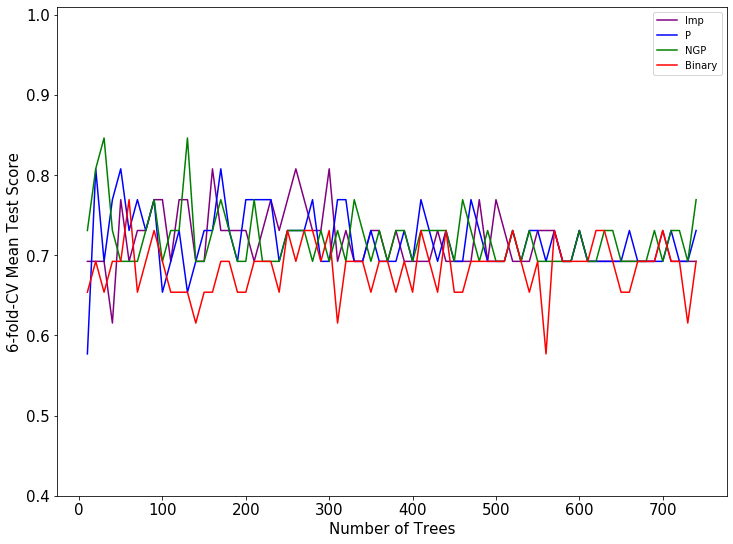

In [71]:
f, ax = plt.subplots(figsize=(12,9))
color = ['purple','blue','green','red']*2
for i in range(0,4):
    plt.plot(param[i], test_score[i], color = color[i])
plt.ylabel('6-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - DIMS')

Performance based on number of trees - LCMS


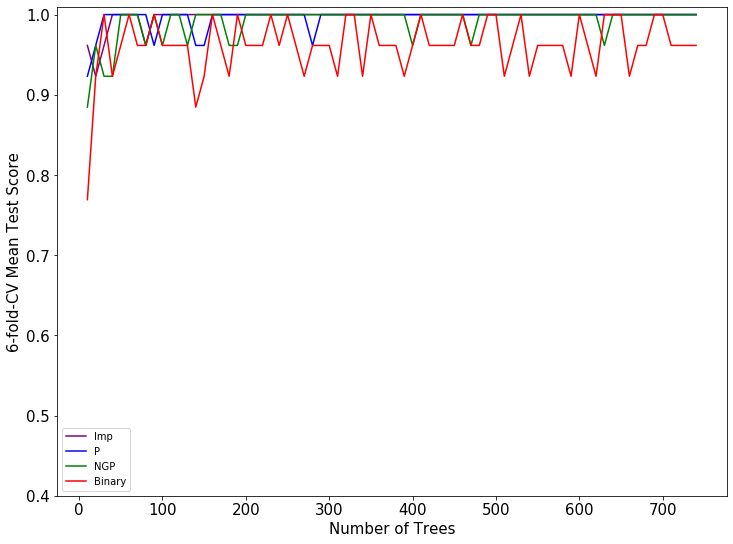

In [72]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(4,8):
    plt.plot(param[i], test_score[i], color = color[i])
plt.ylabel('6-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - LCMS')

### Performance of N, NP and NGP data treatments

See performance of all treatments and absence of them using method nº1 (simple application of random forests), see below.

In [73]:
Teste = {}
Teste_std = {}
Teste_feat = {}

In [74]:
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data, n_fold = 6) #, iter_num = 100)
    Teste[name] = rf
    Teste_std[name] = np.std(rf)
    Teste_feat[name] = imp_features
    print(f'done')    

Fitting random forest for I_dims ...done
Fitting random forest for P_dims ...done
Fitting random forest for NGP_dims ...done
Fitting random forest for bin_dims ...done
Fitting random forest for I_lcms ...done
Fitting random forest for P_lcms ...done
Fitting random forest for NGP_lcms ...done
Fitting random forest for bin_lcms ...done


Accuracy based on the dataset


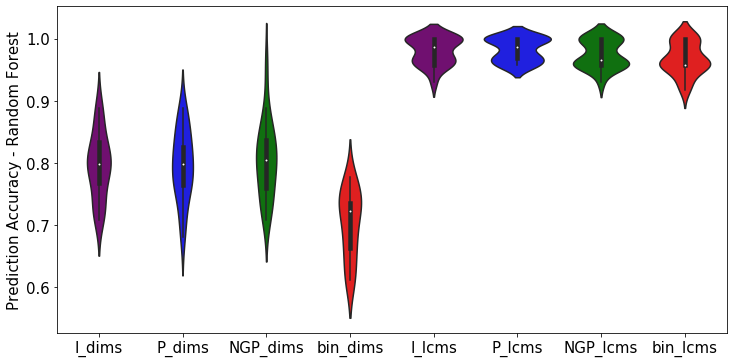

In [75]:
f, ax = plt.subplots(figsize=(12,6))
colors = ['purple','blue','green','red']
sns.violinplot(data=pd.DataFrame.from_dict(Teste), palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
print('Accuracy based on the dataset')

In [76]:
#Here is median
Teste_A = {}
for i in Teste:
    Teste_A[i] = np.median(Teste[i])

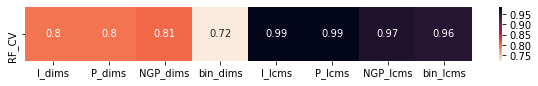

In [77]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys(), columns = ['Accuracy']).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])

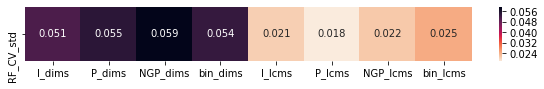

In [78]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

Accuracy plot with errors bars corresponding to the 95% confidence interval and accurcy and standard deviation tables

In [79]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Teste_ic = Teste_std_H / (100**0.5)*1.96

In [80]:
#sns.set_context('notebook')

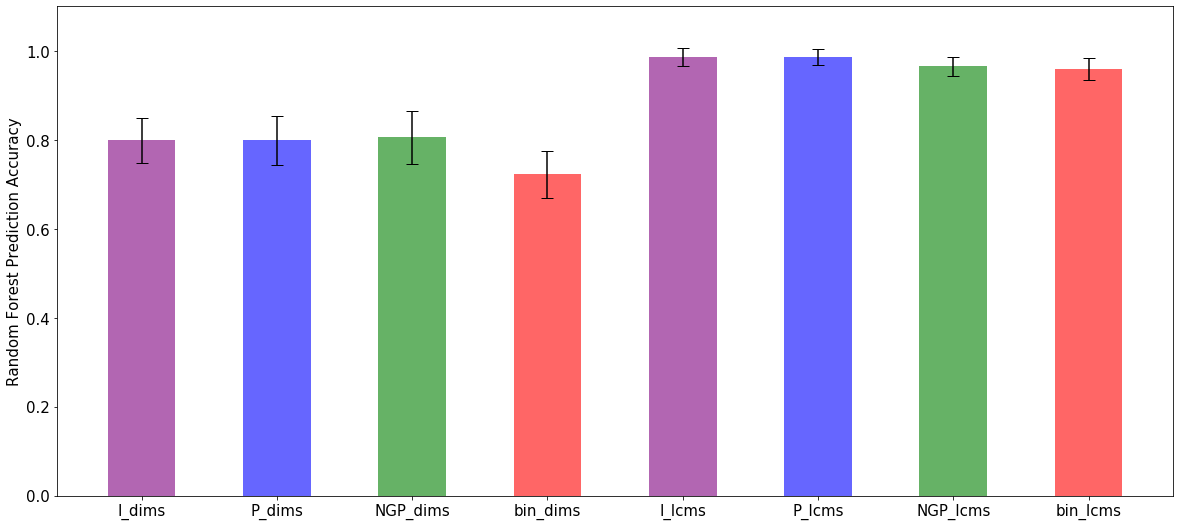

In [81]:
f, ax = plt.subplots(figsize=(20, 9))
#sns.set_context('talk')
color = ['purple','blue','green','red']
plt.bar(height = Teste_H.T['Accuracy'], x = Teste_H.columns, width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns, y = Teste_H.T['Accuracy'], yerr = Teste_std_H.iloc[0,:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.10)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

### Attempt/Method nº1 - Direct

### Simple application of random forests

The random forest classification is iterated iter_num times to make sure more combinations of training and test samples are used. Then, an average of the results are obtained. 

N-fold Cross-Validation is used as an internal validation system evaluating the performance of the model based on its score/prediction accuracy - the number of folds used will be the one that seems most appropriate in each case. For balanced datasets n_fold = number of replicates in each group if the number of replicates is under 10.

Besides the n-fold cross-validation score, the order of the average of most important features across the random forests (with each iteration and group in cross-validation having the same weight) is extracted from the forests "built".

Application of the function `simple_RF` from multianalysis.

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive)

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A swarmplot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

In [82]:
#Getting the number of samples, groups, ratios for each important feature, 
#magnitude for most important feature and calculating % explained by these features (more)
ev = []
magni = []
more = []
for name in Teste_feat:#['neg2-1_direct']:
    if name.endswith('dims'):
        #continue
        Spectra = aligned_all_dims
    elif name.endswith('lcms'):
        #continue
        Spectra = aligned_all_lcms
        
    imp_features = Teste_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    magni.append(imp_features[0][1]/(1/len(Spectra)))
    
    a = 0
    for i in range(number): 
        a = a + imp_features[i][1]*100 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    more.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [83]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Teste_feat]) #if '2-1' in i])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8]])

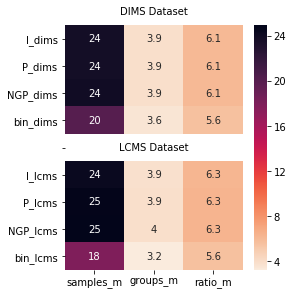

In [84]:
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'DIMS Dataset',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'LCMS Dataset',horizontalalignment='center', verticalalignment='center')
plt.show()

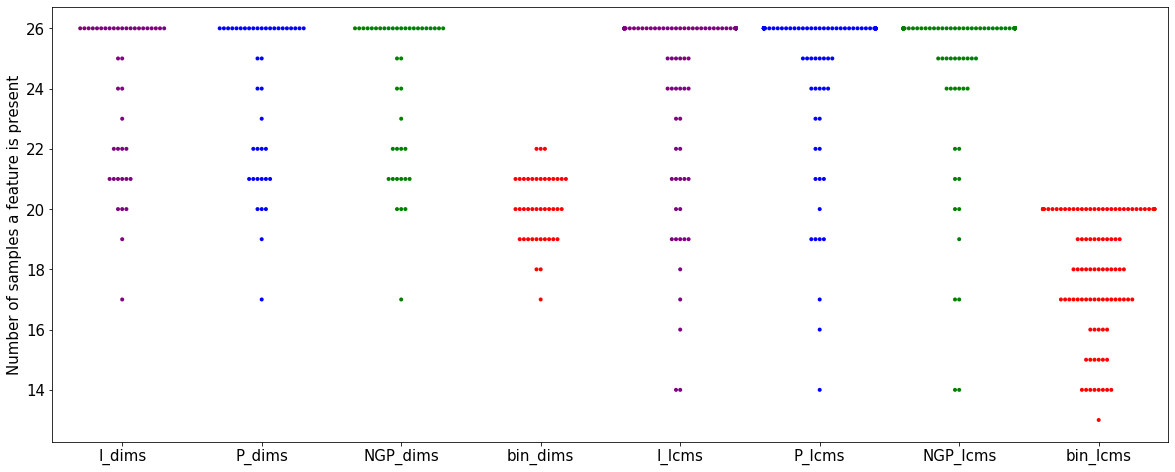

In [85]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 4, palette = ['purple','blue','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [86]:
print('Magnitude of most important feature:', )
for i in range(8):
    print(list(Teste_feat.keys())[i], '     \t', magni[i])
    
print('\n')
print('% of model explained by the 2% most important features')
for i in range(8):
    print(list(Teste_feat.keys())[i], '     \t', more[i])

Magnitude of most important feature:
I_dims      	 13.358647591242883
P_dims      	 14.266331024553732
NGP_dims      	 13.394079995010685
bin_dims      	 26.666856681849403
I_lcms      	 6.658597093815205
P_lcms      	 6.636315598262374
NGP_lcms      	 7.794877625309544
bin_lcms      	 40.68253422263275


% of model explained by the 2% most important features
I_dims      	 17.15811283771319
P_dims      	 17.1371131632048
NGP_dims      	 17.048870627891624
bin_dims      	 26.502930347690207
I_lcms      	 8.773771956210368
P_lcms      	 8.75202869222518
NGP_lcms      	 8.769412451817557
bin_lcms      	 32.59584036298492


### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

### Search for the best number of components to use

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with n-fold cross-validation (same judgement as the one done in the random forests for the cross-validation). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 50 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function `optim_PLS` in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [87]:
PLS_optim = {}

In [88]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 30, n_fold = 6)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for I_dims ...done
Optimizing PLS-DA for P_dims ...done
Optimizing PLS-DA for NGP_dims ...done
Optimizing PLS-DA for bin_dims ...done
Optimizing PLS-DA for I_lcms ...done
Optimizing PLS-DA for P_lcms ...done
Optimizing PLS-DA for NGP_lcms ...done
Optimizing PLS-DA for bin_lcms ...done


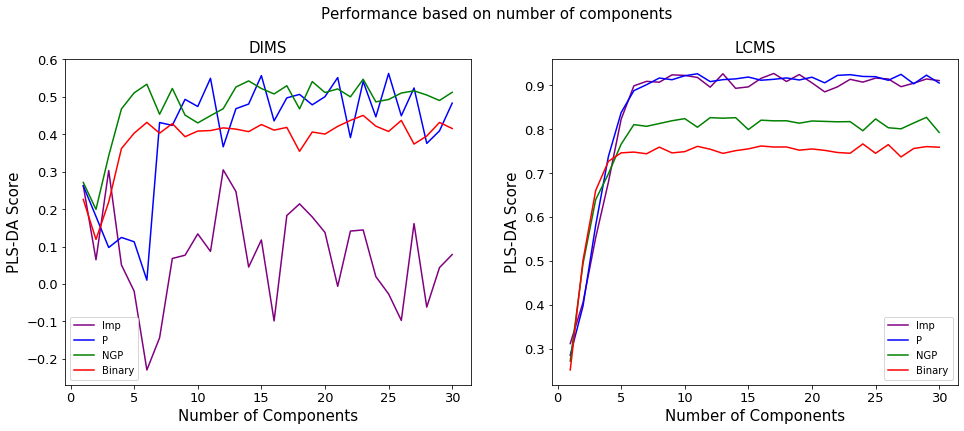

In [89]:
f, axes = plt.subplots(1, 2, figsize = (16,6))
quadrant = [axes[0], axes[1]]
plt.suptitle('Performance based on number of components', fontsize = 15, x = 0.5, y = 1)
color = ['purple','blue','green','red']*2
i = 0

for name, data in PLS_optim.items():
    if name.endswith('dims'):
        quadrant[0].plot(range(1,31),data, color[i])
        quadrant[0].set_xlabel('Number of Components', fontsize=15)
        quadrant[0].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[0].set_title('DIMS', fontsize=15)
        quadrant[0].tick_params(axis='both', which='major', labelsize=13)
        quadrant[0].legend(('Imp', 'P', 'NGP', 'Binary'))
    if name.endswith('lcms'):
        quadrant[1].plot(range(1,31),data, color[i])
        quadrant[1].set_xlabel('Number of Components', fontsize=15)
        quadrant[1].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[1].set_title('LCMS', fontsize=15)
        quadrant[1].tick_params(axis='both', which='major', labelsize=13)
        quadrant[1].legend(('Imp', 'P', 'NGP', 'Binary'))
    i = i+1

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better was the numebr of components used in each case. 

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in k different groups as k-fold cross-validation.

In [90]:
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [91]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 10, iter_num = 100, n_fold = 6, feat_type = 'Coef')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done')    

Fitting PLS-DA for I_dims ...done
Fitting PLS-DA for P_dims ...done
Fitting PLS-DA for NGP_dims ...done
Fitting PLS-DA for bin_dims ...done
Fitting PLS-DA for I_lcms ...done
Fitting PLS-DA for P_lcms ...done
Fitting PLS-DA for NGP_lcms ...done
Fitting PLS-DA for bin_lcms ...done


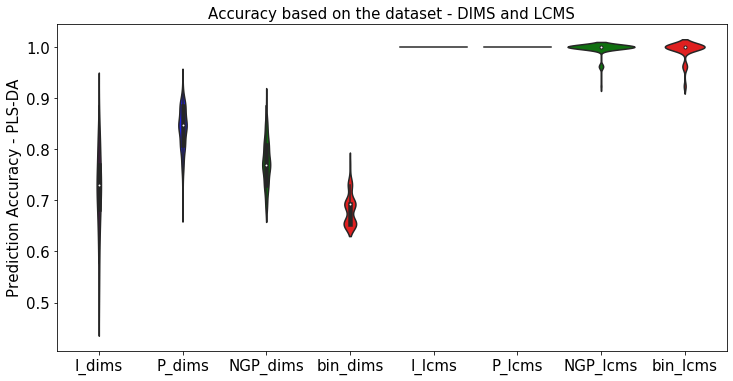

In [92]:
f, ax = plt.subplots(figsize=(12,6))
colors = ['purple','blue','green','red']
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
plt.title('Accuracy based on the dataset - DIMS and LCMS', fontsize = 15)
plt.show()

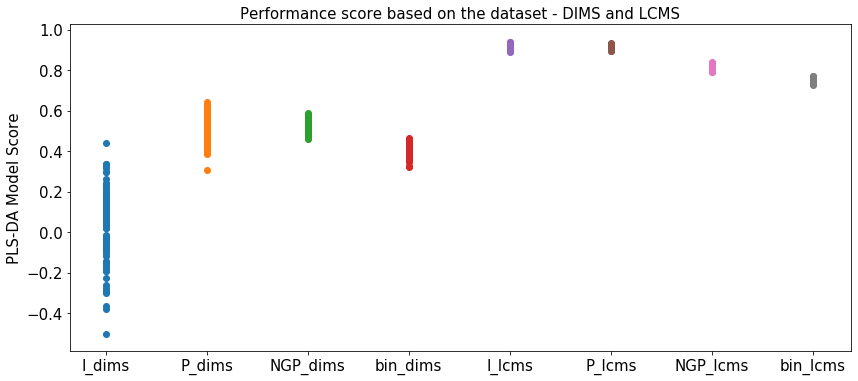

In [93]:
f, ax = plt.subplots(figsize=(14,6))
for name, data in PLS_score.items():
    plt.scatter([name]*len(data), data)
plt.ylabel('PLS-DA Model Score', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Performance score based on the dataset - DIMS and LCMS', fontsize = 15)
plt.show()

### Medians but also still with standard deviations

In [94]:
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.median(PLS_accu[name])
    Score[name] = np.median(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

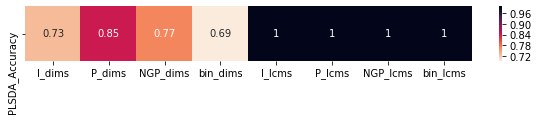

In [95]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

plt.show()

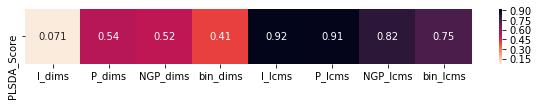

In [96]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [97]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

,Accuracy,SD
I_dims,0.730769,0.081112
P_dims,0.846154,0.042482
NGP_dims,0.769231,0.043269
bin_dims,0.692308,0.029978
I_lcms,1.000000,0.000000
P_lcms,1.000000,0.000000
NGP_lcms,1.000000,0.011767
bin_lcms,1.000000,0.018349


In [98]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).T
Score_H.loc['SD'] = list(Score_std.values())
Score_H.T

,Score,SD
I_dims,0.070809,0.174184
P_dims,0.537308,0.062236
NGP_dims,0.519215,0.028196
bin_dims,0.408027,0.026714
I_lcms,0.918946,0.010403
P_lcms,0.914881,0.007767
NGP_lcms,0.816931,0.009583
bin_lcms,0.752500,0.008722


### Characteristics of the most important features

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [99]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev = []
magni = []
index = []

for name in PLS_feat:
    if name.endswith('dims'):
        Spectra = aligned_all_dims
    elif name.endswith('lcms'):
        Spectra = aligned_all_lcms
    
    imp_features = PLS_feat[name]
    
    index.append(name)
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    total_m = 0
    
    for i in range(len(imp_features)):
        total_m = total_m + imp_features[i][1]
    magni.append(imp_features[0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [100]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8]])

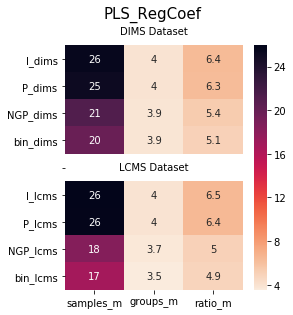

In [101]:
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('PLS_RegCoef', fontsize = 15, x = 0.43, y = 1)
plt.text(1.5,-0.5,'DIMS Dataset',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'LCMS Dataset',horizontalalignment='center', verticalalignment='center')
plt.show()

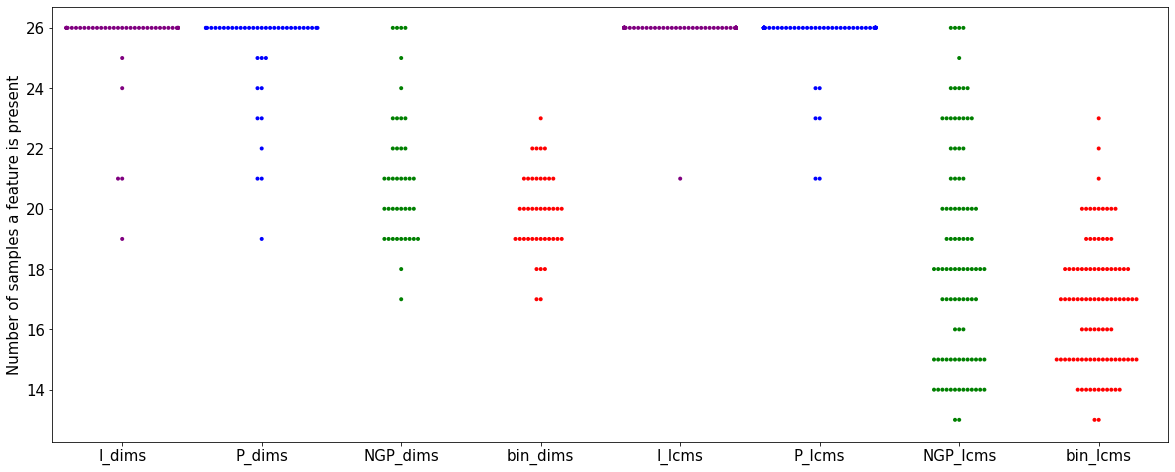

In [102]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]

sns.swarmplot(data=data, size = 4, palette = ['purple','blue','green','red']*2)
ax.set(xticklabels = [list(PLS_feat.keys())[i] for i in range(len(PLS_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [103]:
print('Magnitude of most important features for each case:')
for i in range(8):
    print(list(PLS_feat.keys())[i], '     \t', magni[i])

Magnitude of most important features for each case:
I_dims      	 40.10034764681416
P_dims      	 11.450010597990644
NGP_dims      	 5.1641315562719265
bin_dims      	 9.079210188140292
I_lcms      	 97.92857483817981
P_lcms      	 21.828956641822867
NGP_lcms      	 5.18603791988121
bin_lcms      	 9.75587078860595


### Example of models built with the full dataset and sample representation on the two most important Components/Latent Variables

In [104]:
def plot_PLSDA(principaldf, label_colors, components=(1,2), title="PLS-DA", ax=None):
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    with sns.axes_style("whitegrid"):
        #ax.axis('equal')
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

        unique_labels = principaldf['Label'].unique()

        for lbl in unique_labels:
            subset = principaldf[principaldf['Label']==lbl]
            ax.scatter(subset[col_c1_name],
                       subset[col_c2_name],
                       s=50, color=label_colors[lbl], label=lbl)

        ax.legend(framealpha=1)
        ax.set_title(title, fontsize=15)

#### NGP data treatment for the DIMS Dataset

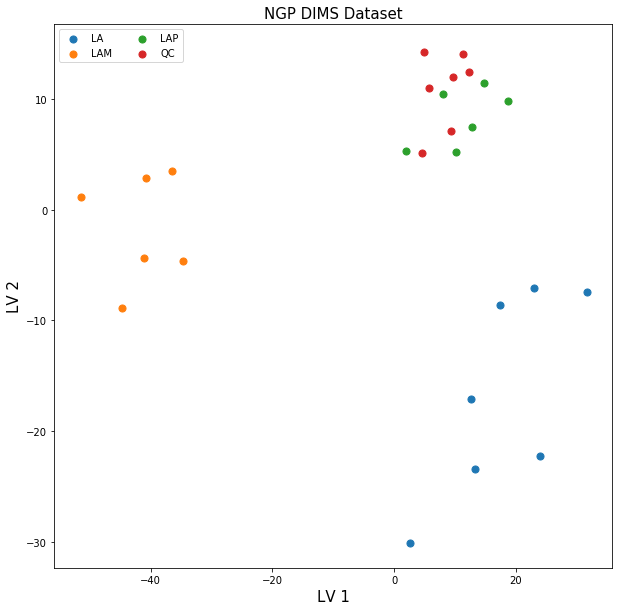

In [105]:
n_components = 10

plsreg_GPneg = ma.PLSscores_with_labels(NGP_dims, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP DIMS Dataset", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### Binary processed data for the DIMS Dataset

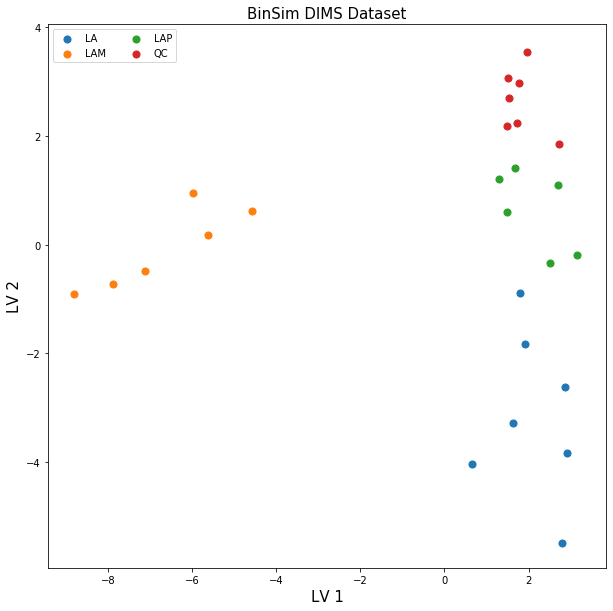

In [106]:
n_components = 10

plsreg_GPneg = ma.PLSscores_with_labels(aligned_dims, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim DIMS Dataset", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### NGP data treatment for the LCMS Dataset

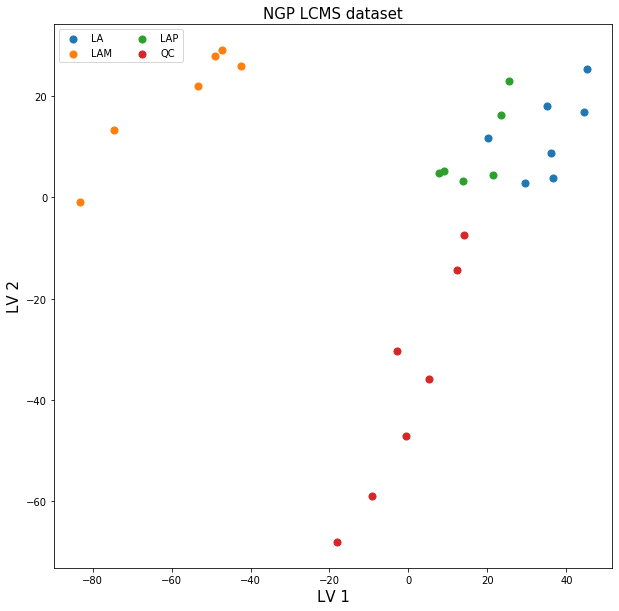

In [107]:
n_components = 4

plsreg_GPneg = ma.PLSscores_with_labels(NGP_lcms, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP LCMS dataset", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### Binary processed data for the LCMS Dataset

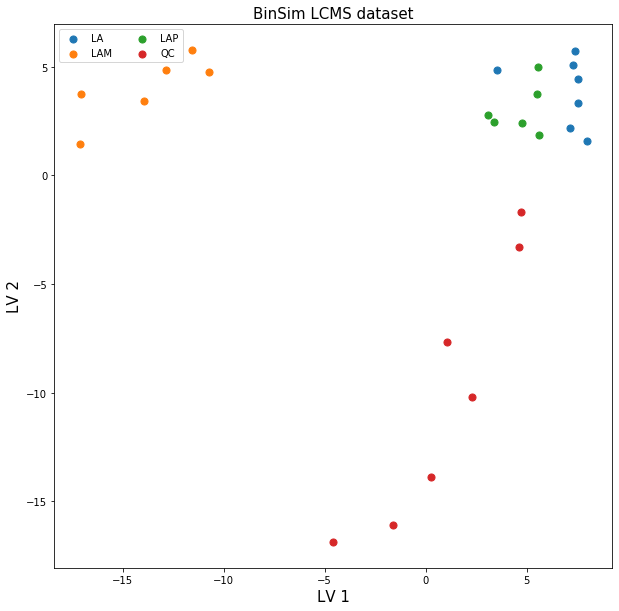

In [108]:
n_components = 4

plsreg_GPneg = ma.PLSscores_with_labels(aligned_lcms, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim LCMS dataset", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

### Permutation Tests - Random Forests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is random forests or pls-da found a significant class structure in the data. 

For that a random k-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 150 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Use of function `permutation_RF` in multianalysis.py

In [109]:
CV = {}
PMs = {}
pvalue = {}

In [110]:
all_data = (Imp_dims, P_dims, NGP_dims, aligned_dims, Imp_lcms, P_lcms, NGP_lcms, aligned_lcms)
names = ('Imp_dims', 'P_dims', 'NGP_dims', 'bin_dims', 'Imp_lcms', 'P_lcms', 'NGP_lcms', 'bin_lcms')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=6)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for Imp_dims ...
Done!
Permutation test (Random Forest) for P_dims ...
Done!
Permutation test (Random Forest) for NGP_dims ...
Done!
Permutation test (Random Forest) for bin_dims ...
Done!
Permutation test (Random Forest) for Imp_lcms ...
Done!
Permutation test (Random Forest) for P_lcms ...
Done!
Permutation test (Random Forest) for NGP_lcms ...
Done!
Permutation test (Random Forest) for bin_lcms ...
Done!


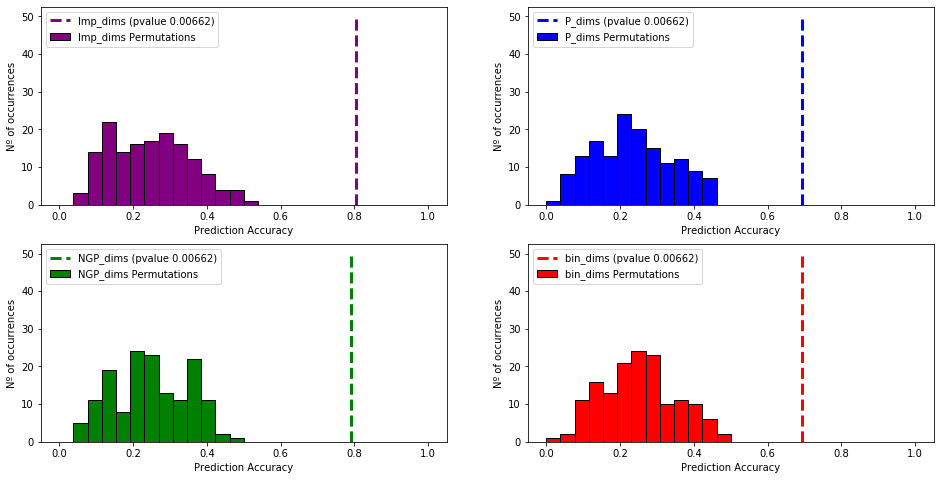

In [111]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_dims', 'P_dims', 'NGP_dims', 'bin_dims']
color = ['purple','blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_dims.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

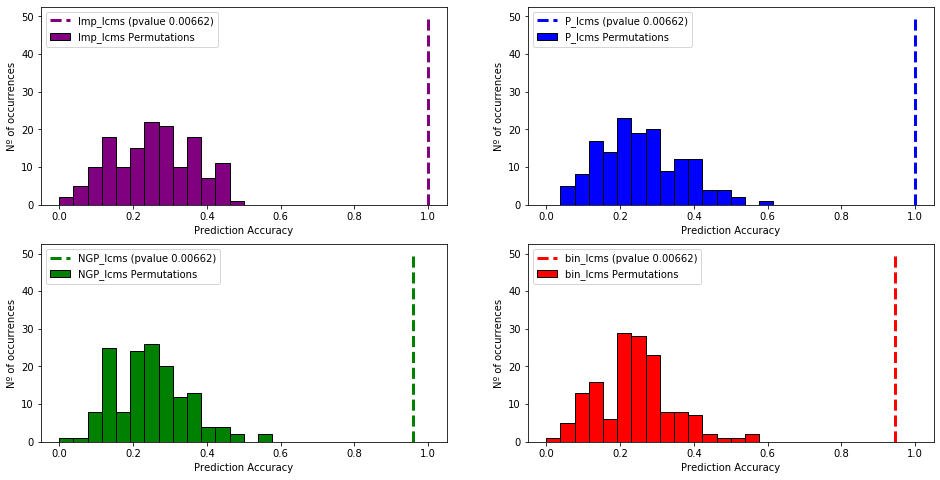

In [112]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_lcms', 'P_lcms', 'NGP_lcms', 'bin_lcms']
color = ['purple', 'blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_lcms.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [113]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [114]:
all_data = (Imp_dims, P_dims, NGP_dims, aligned_dims, Imp_lcms, P_lcms, NGP_lcms, aligned_lcms)
names = ('Imp_dims', 'P_dims', 'NGP_dims', 'bin_dims', 'Imp_lcms', 'P_lcms', 'NGP_lcms', 'bin_lcms')

for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp = 10, iter_num = 150, n_fold = 6)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for Imp_dims ...
Done!
permutation test (PLS-DA) for P_dims ...
Done!
permutation test (PLS-DA) for NGP_dims ...
Done!
permutation test (PLS-DA) for bin_dims ...
Done!
permutation test (PLS-DA) for Imp_lcms ...
Done!
permutation test (PLS-DA) for P_lcms ...
Done!
permutation test (PLS-DA) for NGP_lcms ...
Done!
permutation test (PLS-DA) for bin_lcms ...
Done!


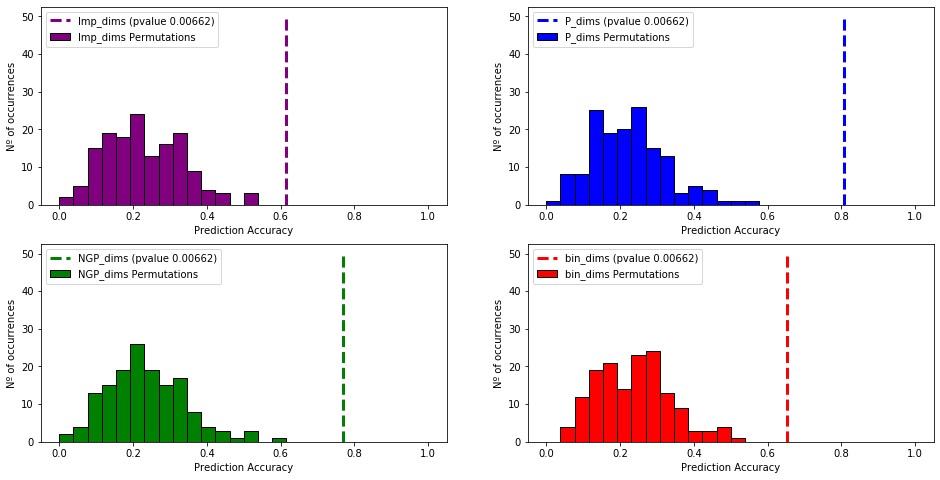

In [115]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_dims', 'P_dims', 'NGP_dims', 'bin_dims']
color = ['purple','blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_dims.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

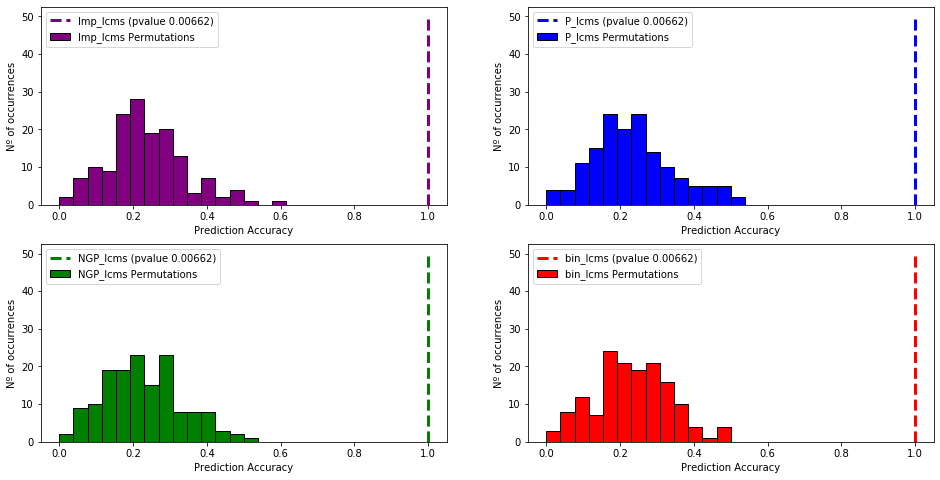

In [116]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_lcms', 'P_lcms', 'NGP_lcms', 'bin_lcms']
color = ['purple', 'blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_lcms.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()